# Learning the quantum engineered task and the classical task using                classical feedforward neural networks (FFNN)

In [37]:
using Yao, YaoPlots, Plots
using LinearAlgebra, Statistics, Random, StatsBase, MAT, Printf 
using Flux: batch, Flux 
using Flux
using MultivariateStats, StatsBase, Statistics 
using Zygote
using DataFrames 
using JLD
include("../functions/Function_QCL.jl") ; 

# Quantum engineered task

## The ground truth label of each input sample is determined by a local observable                  evolved under a quantum circuit with randomly chosen gate parameters.

In [16]:
num_qubit = 10 ;
depth = 3 ;

mid = 1 ;

op0 = put(num_qubit, mid=>0.5*(I2+Z)) ;
op1 = put(num_qubit, mid=>0.5*(I2-Z)) ;

In [17]:
pca_dim = num_qubit ; # choose principal features

In [18]:
num_train = 1000 ;
num_test = 200 ;

data1 = matread("../dataset/FashionMNIST_0-9.mat")
x_train_1 = real(data1["x_train"][ :, 1 : num_train ]) ; 
y_train_1 = data1["y_train"][ 1 : num_train, : ] ;
x_test_1 = real(data1["x_test"][ :, 1 : num_test ] ) ;  
y_test_1 = data1["y_test"][ 1 : num_test, : ]  ;

In [19]:
x_all = hcat( x_train_1, x_test_1 ) ;

# PCA 
pca_model = fit(PCA, x_all, maxoutdim = pca_dim) ;
trans_X = MultivariateStats.transform(pca_model, x_all) ;
X_std = std( trans_X, dims = 2 ) ; trans_X = trans_X ./ X_std ;  # normalize

# encoding to Rzz gate
trans_X_1 = zeros(pca_dim-1, size(x_all)[2])

for i in 1 : pca_dim-1
    trans_X_1[i, :] =  4 .* trans_X[i, :] .* trans_X[i+1, :]
end

# two layers of encoding
XX = vcat(trans_X, trans_X_1, trans_X, trans_X_1)

trans_x_train_1 = XX[ :, 1 : num_train] ;
trans_x_test_1 = XX[ :, num_train+1 : end] ;

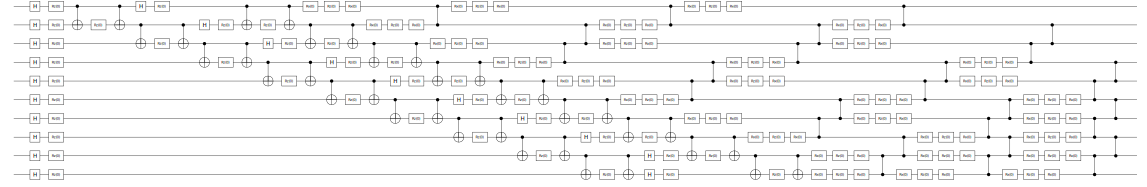

In [20]:
chain_1(nbit::Int64) = chain( H_chain(nbit),  rz_layer(nbit, 1:nbit) ) ;
chain_2(nbit::Int64) = chain( nbit, chain( control(i,i+1=>X), put(i+1 => Rz(0)), control(i,i+1=>X) ) 
                                       for i in 1 : nbit-1) ;

circuit_encoding(nbit::Int64)  = chain( chain_1(nbit), chain_2(nbit), chain_1(nbit), chain_2(nbit) ) ;
circuit_encoding_2(nbit::Int64)  = chain( rx_layer(nbit, 1:nbit), ent_cx(nbit, 1:nbit) )  ;

circuit_variational(nbit::Int64, depth)  = chain( chain(nbit, params_layer(nbit, 1:nbit), 
                       ent_cz(nbit, 1:nbit)) for _ in 1 : depth ) ;

circuit = chain( circuit_encoding(num_qubit), circuit_variational(num_qubit, depth) ) ;
dim = nparameters(circuit) ;
YaoPlots.plot(circuit)

In [21]:
target_params = matread("target_params_10.mat")["target_params"] ;

In [22]:
train_cir_1 = [ chain( circuit_encoding(num_qubit), circuit_variational(num_qubit, depth) )   
    for _ in 1 : num_train] ;

test_cir_1  = [ chain( circuit_encoding(num_qubit), circuit_variational(num_qubit, depth) )  
    for _ in 1 : num_test] ;

for i in 1 : num_train
    dispatch!( train_cir_1[i], vcat( trans_x_train_1[:, i], target_params ) ) ;
end

for i in 1 : num_test
    dispatch!(test_cir_1[i], vcat( trans_x_test_1[:, i], target_params )) ;
end

In [23]:
q_train = zeros(num_train, 2) ;
for i = 1 : num_train
    res = zero_state(num_qubit) |> train_cir_1[i]
    rdm = density_matrix(res, (mid))
    q_train[i,:] = rdm |> probs
end

y_train_1_re = zeros(num_train, 2) ;

for i in 1 : num_train
    if q_train[i, 1] < 0.5
        y_train_1_re[ i, : ] = [0 , 1]
    else
        y_train_1_re[ i, : ] = [1 , 0]
    end
end

In [24]:
q_test = zeros(num_test, 2) ;

for i = 1 : num_test
    res = zero_state(num_qubit) |> test_cir_1[i]
    rdm = density_matrix(copy(res), (mid))
    q_test[i, :] = rdm |> probs
end

y_test_1_re = zeros(num_test, 2) ;

for i in 1 : num_test
    if q_test[i, 1] < 0.5
        y_test_1_re[ i, : ] = [0 , 1]
    else
        y_test_1_re[ i, : ] = [1 , 0]
    end
end

In [25]:
@show  sum( abs(q_train[i,1] - q_train[i,2]) >=0.2 for i in 1:num_train )
@show  sum( (q_train[i,1] - q_train[i,2]) >=0.2 for i in 1:num_train )
@show  sum( (q_train[i,1] - q_train[i,2]) < -0.2 for i in 1:num_train )
@show  sum( abs(q_test[i,1] - q_test[i,2]) >=0.2 for i in 1:num_test )
@show  sum( (q_test[i,1] - q_test[i,2]) >=0.2 for i in 1:num_test )
@show  sum( (q_test[i,1] - q_test[i,2]) < -0.2 for i in 1:num_test ) ;

sum((abs(q_train[i, 1] - q_train[i, 2]) >= 0.2 for i = 1:num_train)) = 582
sum((q_train[i, 1] - q_train[i, 2] >= 0.2 for i = 1:num_train)) = 347
sum((q_train[i, 1] - q_train[i, 2] < -0.2 for i = 1:num_train)) = 235
sum((abs(q_test[i, 1] - q_test[i, 2]) >= 0.2 for i = 1:num_test)) = 120
sum((q_test[i, 1] - q_test[i, 2] >= 0.2 for i = 1:num_test)) = 69
sum((q_test[i, 1] - q_test[i, 2] < -0.2 for i = 1:num_test)) = 51


In [26]:
index_test = [i for i in 1:num_test if abs(q_test[i, 1] - q_test[i, 2]) >= 0.2] ;
index_train = [i for i in 1:num_train if abs(q_train[i, 1] - q_train[i, 2]) >= 0.2]  ;

num_train_re = length(index_train) ;  num_test_re = length(index_test) ;

In [27]:
# Choose the data with abs(<Z>) > 0.1 as the dataset
se_y_test_1_re = y_test_1_re[index_test, :]  ;
se_y_train_1_re = y_train_1_re[index_train, :] ;

se_y_train_1 = y_train_1[index_train, :] ;
se_y_test_1 = y_test_1[index_test, :] ;

quantum_trans_x_train_1 = trans_x_train_1[:, index_train] ;
quantum_trans_x_test_1 = trans_x_test_1[:, index_test] ;

classical_x_train_1 = quantum_trans_x_train_1[1 : pca_dim , :]
classical_x_test_1 = quantum_trans_x_test_1[1 : pca_dim , :] ;

# Classical task

In [71]:
circuit_2 = chain( circuit_encoding_2(num_qubit), circuit_variational(num_qubit, depth) ) ;
dim_2 = nparameters(circuit_2) ;
# YaoPlots.plot(circuit_2)

In [30]:
num_train_2 = 500 ;
num_test_2 = 100 ;

# pca 处理
data2 = matread("../dataset/MedNIST_hand_breast_wk.mat")

x_train_2 = real(data2["x_train"][ :, 1 : num_train_2 ]) ; 
y_train_2 = data2["y_train"][ 1 : num_train_2, : ] ;
x_test_2 = real(data2["x_test"][ :, 1 : num_test_2 ] ) ;  
y_test_2 = data2["y_test"][ 1 : num_test_2, : ]  ;

In [31]:
x_all_2 = hcat( x_train_2, x_test_2 ) ;

# PCA 
pca_model_2 = fit(PCA, x_all_2, maxoutdim = pca_dim) ;
trans_X_ = MultivariateStats.transform(pca_model_2, x_all_2) ;
X_std_2 = std( trans_X_, dims = 2 ) ; trans_X_ = trans_X_ ./ X_std_2 ;  # normalize

x_train_2 =  trans_X_[:, 1 : num_train_2]
x_test_2 =  trans_X_[:, num_train_2+1 : end] ;

# Learning using classical FFNNs

## Defining some functions

In [48]:
# loss function
loss(x, y) = Flux.crossentropy(vcat(model_1(x ), 1 .- model_1(x )) , y)

function acc(x, y)
    y_pred = [ t[1] for t in argmax( vcat(model_1(x), 1 .- model_1(x)),  dims =1 ) ]
    y_true = [ t[1] for t in argmax( y,  dims =1 ) ] ;

    return sum(y_pred .== y_true) / size(x, 2)

end

loss_2(x, y) = Flux.crossentropy(vcat(model_1(x ), 1 .- model_1(x )) , y) 

loss_2 (generic function with 1 method)

In [81]:
# quantum engineered task
function learning_1(lr1, epochs1)
    
    c_history_loss_train_1nd_1 = Float64[]
    c_history_acc_train_1nd_1 = Float64[]
    c_history_loss_test_1nd_1 = Float64[] ;
    c_history_acc_test_1nd_1 = Float64[] ;
    c_para_1_history = [] ;
    
    opt = Flux.ADAM(lr1)

    data_batch = Flux.Data.DataLoader((classical_x_train_1, se_y_train_1_re'), batchsize = 25, shuffle=true ) 

    for k in 1 : epochs1

        loss_train_1nd_1 = loss(classical_x_train_1, se_y_train_1_re') ;  acc_train_1nd_1 = acc(classical_x_train_1, se_y_train_1_re')
        loss_test_1nd_1 = loss(classical_x_test_1, se_y_test_1_re') ;   acc_test_1nd_1 = acc(classical_x_test_1, se_y_test_1_re')
        
        ps = Flux.params(model_1)
        push!( c_para_1_history, deepcopy(ps))  
        
        push!(c_history_loss_train_1nd_1, loss_train_1nd_1 ) ;   push!(c_history_acc_train_1nd_1, acc_train_1nd_1) 
        push!(c_history_loss_test_1nd_1, loss_test_1nd_1) ;   push!(c_history_acc_test_1nd_1, acc_test_1nd_1)

#         @printf("\nStep=%d, train_loss=%.3f, train_acc=%.3f\n", k, loss_train_1nd_1, acc_train_1nd_1)
#         @printf("\nStep=%d, test_loss=%.3f, test_acc=%.3f\n", k, loss_test_1nd_1, acc_test_1nd_1)

        Flux.train!(loss, ps, data_batch, opt)
    end
    
    c_history_loss_train_1nd_1, c_history_acc_train_1nd_1, c_history_loss_test_1nd_1, c_history_acc_test_1nd_1, c_para_1_history 
end

learning_1 (generic function with 1 method)

In [82]:
# c_para_1_history[end]
# ps

In [83]:
# Fisher_matrix
function Fisher(ps)
    
    g = Flux.gradient(() -> loss(classical_x_train_1[:, 1], se_y_train_1_re'[:, 1]), ps)
    fisher_t = copy(g) ;
    [ fisher_t[ ps[i] ] .= 0 for i in 1 : length(ps) ] ;

    for i in 1 : num_train_re
        grads = Flux.gradient(() -> loss(classical_x_train_1[:, i], se_y_train_1_re'[:, i]), ps)
        fisher_ = copy(grads) ;
        [ fisher_[ ps[i] ] = fisher_[ ps[i] ] .^ 2  for i in 1 : length(ps) ] ;

        fisher_t .+= fisher_
    end
    fisher_t  = fisher_t ./ num_train_re
    
    fisher_t
    
end

Fisher (generic function with 1 method)

In [84]:
# fisher_t[ps[2]]

In [87]:
# classical task
function learning_2(lr2, epochs2, lambda2, fisher_t, c_para_1_history )
    
    c_history_acc_train_2nd_2 = Float64[] ;   c_history_acc_test_2nd_2 = Float64[] ;
    c_history_loss_train_2nd_2 = Float64[] ;   c_history_loss_test_2nd_2 = Float64[] ;

    c_history_acc_test_2nd_1 = Float64[] ;   c_history_loss_test_2nd_1 = Float64[] ;
    c_history_acc_train_2nd_1 = Float64[] ;   c_history_loss_train_2nd_1 = Float64[] ;
    
    opt2 = Flux.ADAM(lr2)

    data_batch2 = Flux.Data.DataLoader((x_train_2, y_train_2'), batchsize = 25, shuffle=true ) 

    for k in 1 : epochs2

        loss_train_2nd_2 = loss_2(x_train_2, y_train_2') ;   acc_train_2nd_2 = acc(x_train_2, y_train_2')
        loss_test_2nd_2 = loss_2(x_test_2, y_test_2') ;   acc_test_2nd_2 = acc(x_test_2, y_test_2')

        loss_train_2nd_1 = loss(classical_x_train_1, se_y_train_1_re') ;  acc_train_2nd_1 = acc(classical_x_train_1, se_y_train_1_re')
        loss_test_2nd_1 = loss(classical_x_test_1, se_y_test_1_re') ;   acc_test_2nd_1 = acc(classical_x_test_1, se_y_test_1_re')

        push!(c_history_acc_train_2nd_2, acc_train_2nd_2) ;    push!(c_history_loss_train_2nd_2, loss_train_2nd_2) ;   
        push!(c_history_acc_test_2nd_2, acc_test_2nd_2) ;    push!(c_history_loss_test_2nd_2, loss_test_2nd_2) ;   

        push!(c_history_acc_train_2nd_1, acc_train_2nd_1) ;    push!(c_history_loss_train_2nd_1, loss_train_2nd_1) ;  
        push!(c_history_acc_test_2nd_1, acc_test_2nd_1) ;    push!(c_history_loss_test_2nd_1, loss_test_2nd_1) ;  


#         @printf("Step=%d, train_loss=%.3f, train_acc=%.3f\n", k, loss_train_2nd_2, acc_train_2nd_2)
#         @printf("Step=%d, test_loss=%.3f, test_acc=%.3f\n", k, loss_test_2nd_2, acc_test_2nd_2)

#         @printf("train_task1, loss=%.3f, acc=%.3f\n", loss_train_2nd_1, acc_train_2nd_1)
#         @printf("task1, loss=%.3f, acc=%.3f\n", loss_test_2nd_1, acc_test_2nd_1)

        ps = Flux.params(model_1)
        for (x, y) in data_batch2
            grads = Flux.gradient(() -> loss_2(x, y), ps)

            for i in 1 : length(ps)
                grads[ps[i]] = grads[ps[i]] + lambda2 * fisher_t[ps[i]] .* (ps[i]  - c_para_1_history[end][i])
            end

            Flux.update!(Flux.Adam(lr2), ps, grads)

        end
    end
        
    c_history_acc_train_2nd_2, c_history_acc_test_2nd_2, c_history_loss_train_2nd_2, c_history_loss_test_2nd_2, 
    c_history_acc_test_2nd_1,  c_history_loss_test_2nd_1, c_history_acc_train_2nd_1,  c_history_loss_train_2nd_1
end

learning_2 (generic function with 1 method)

## Classical learning with different regularization strengths in the EWC method

In [33]:
# build the FFNN model

input_size = size(classical_x_train_1, 1)
output_size = 1
hidden_size = 20 ;

model_1 = Flux.Chain(
    Flux.Dense(input_size, hidden_size, Flux.σ; init = Flux.randn ),
    Flux.Dense(hidden_size, output_size, Flux.σ; init = Flux.randn),
)     |> Flux.f64

total_params = sum(length, Flux.params(model_1)) ;
@show model_1

model_1 = Chain(Dense(10 => 20, σ), Dense(20 => 1, σ))


Chain(
  Dense(10 => 20, σ),                   # 220 parameters
  Dense(20 => 1, σ),                    # 21 parameters
)                   # Total: 4 arrays, 241 parameters, 2.133 KiB.

In [97]:
# build the CNN model
model_1 = Chain(

    x -> reshape(x, (input_size, 1, size(x, 2))),
    
    Conv((3,), 1 => 20, relu, pad=1; init = Flux.randn ),
    
    x -> maxpool(x, (2,)),
    
    Flux.flatten,
    
    Dense(100, 1, Flux.σ; init = Flux.randn )
) |> Flux.f64

# 输出模型结构
println(model_1)
@show model_1

Chain(#325, Conv((3,), 1 => 20, relu, pad=1), #326, flatten, Dense(100 => 1, σ))
model_1 = Chain(#325, Conv((3,), 1 => 20, relu, pad=1), #326, flatten, Dense(100 => 1, σ))


Chain(
  var"#325#327"(),
  Conv((3,), 1 => 20, relu, pad=1),     # 80 parameters
  var"#326#328"(),
  MLUtils.flatten,
  Dense(100 => 1, σ),                   # 101 parameters
)                   # Total: 4 arrays, 181 parameters, 1.789 KiB.

In [88]:
C1 = 100 ; num_repeat = 50 ;
learning_results = [Dict() for _ in 1 : num_repeat] ; 
for R in 1 : num_repeat
    
    for lambda2 in 0 : 2 : C1

        model_1 = Flux.Chain(
            Flux.Dense(input_size, hidden_size, Flux.σ; init = Flux.randn ),
            Flux.Dense(hidden_size, output_size, Flux.σ; init = Flux.randn ),
            )     |> Flux.f64

        ps = Flux.params(model_1)

        lr1 = 0.05; epochs1 = 20; 
        lr2 = 0.05; epochs2 = 17; 

        # learning the 1st task
        c_history_loss_train_1nd_1, c_history_acc_train_1nd_1, c_history_loss_test_1nd_1, c_history_acc_test_1nd_1, c_para_1_history = 
                    learning_1(lr1, epochs1)   ;

        ps = Flux.params(model_1)
        # fisher information
        fisher_t = Fisher(ps) ;

        Flux.loadparams!( model_1, c_para_1_history[end] ) ;


        # learning the 2nd task

        c_history_acc_train_2nd_2, c_history_acc_test_2nd_2, c_history_loss_train_2nd_2, c_history_loss_test_2nd_2, 
            c_history_acc_test_2nd_1,  c_history_loss_test_2nd_1, c_history_acc_train_2nd_1,  c_history_loss_train_2nd_1 = 
                      learning_2(lr2, epochs2, lambda2, fisher_t, c_para_1_history)   ;

        learning_results[R][string(lambda2)] = 
        [c_history_loss_train_1nd_1, c_history_acc_train_1nd_1, c_history_loss_test_1nd_1, c_history_acc_test_1nd_1, 
        c_history_acc_train_2nd_2, c_history_acc_test_2nd_2, c_history_loss_train_2nd_2, c_history_loss_test_2nd_2, 
        c_history_acc_test_2nd_1,  c_history_loss_test_2nd_1, c_history_acc_train_2nd_1,  c_history_loss_train_2nd_1] ;

    end
    
end

In [ ]:
# learning_results[1][string(2)]

### FFNN

In [ ]:
save("ffnn_learning_results.jld", "accuracy_loss", learning_results)
# load("ffnn_learning_results.jld")["accuracy_loss"]

In [ ]:
matwrite("ffnn_continual_learning_lambda_40.mat", Dict(
        "task_1" =>  vcat(learning_results[1][string(40)][4], learning_results[1][string(40)][9]),
        "task_2" =>  learning_results[1][string(40)][6]   )
        )   ;

In [ ]:
task_2 = mean([[learning_results[j][string(i)][6][end] for i in 0 : 2 : C1] for j in 1:C2]) 
task_1 = mean([[learning_results[j][string(i)][9][end] for i in 0 : 2 : C1] for j in 1:C2]) 
matwrite("ffnn_continual_learning_for_all_lambda.mat", Dict(
        "lambda" => collect(0 : 2 : C1),
        "task_1" =>  task_1,
        "task_2" =>  task_2   )
        )
# matread("../data/advantage/ffnn_continual_learning_for_all_lambda.mat")

In [ ]:
# learning_results = load("classical_learning_results.jld")["accuracy_loss"] ;

### CNN

In [89]:
save("cnn_learning_results_.jld", "accuracy_loss", learning_results)
matwrite("cnn_continual_learning_lambda_40.mat", Dict(
        "task_1" =>  vcat(learning_results[1][string(40)][4], learning_results[1][string(40)][9]),
        "task_2" =>  learning_results[1][string(40)][6]   )
        )   ;

In [90]:
task_2 = mean([[learning_results[j][string(i)][6][end] for i in 0 : 2 : C1] for j in 1:C2]) 
task_1 = mean([[learning_results[j][string(i)][9][end] for i in 0 : 2 : C1] for j in 1:C2]) 
matwrite("cnn_continual_learning_for_all_lambda.mat", Dict(
        "lambda" => collect(0 : 2 : C1),
        "task_1" =>  task_1,
        "task_2" =>  task_2   )
        )

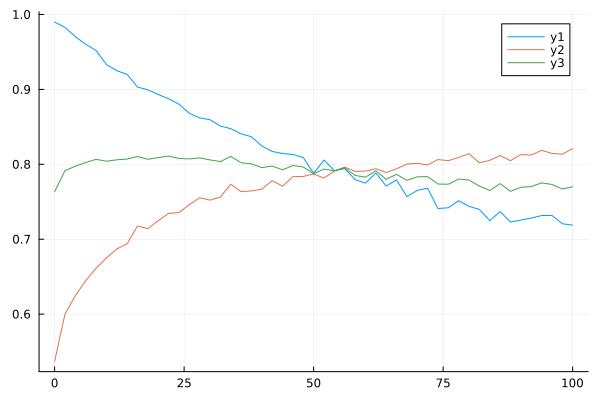

In [91]:
Plots.plot( 0 : 2 : C1, task_2 )
Plots.plot!( 0 : 2 : C1, task_1 )
Plots.plot!( 0 : 2 : C1, (task_2 .+ task_1)/2  )